# Variational Autoencoders (VAE)

In [1]:
import jax
import jax.numpy as jnp
import flax.linen as nn
import matplotlib.pyplot as plt

In [2]:
%config InlineBackend.figure_format = "retina"

In [18]:
# Taken from jax's website
# https://jax.readthedocs.io/en/latest/notebooks/Neural_Network_and_Data_Loading.html
from torchvision.datasets import MNIST


class FlattenAndCast(object):
  def __call__(self, pic):
    return np.ravel(np.array(pic, dtype=jnp.float32))

root = "/tmp/mnist"
mnist_train = MNIST(root, download=True, train=True)
mnist_test = MNIST(root, download=True, train=False)

In [21]:
X_train = jnp.array(mnist_train.data)
n_train, *_ = X_train.shape
# "Gaussanised" MNIST
Xf_train = X_train / X_train.max()
Xf_train = (Xf_train - Xf_train.mean()) / Xf_train.std()

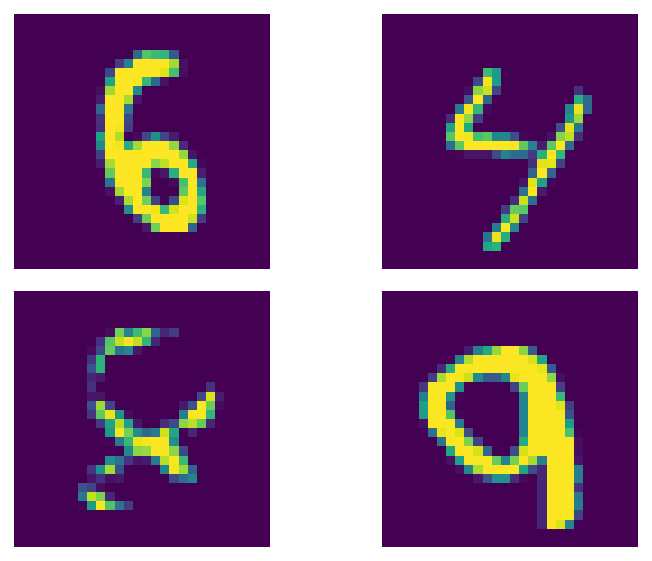

In [27]:
key = jax.random.PRNGKey(314)
ixs = jax.random.choice(key, n_train, (4,))

fig, axs = plt.subplots(2,2)
axs = axs.ravel()
for ix, ax in zip(ixs, axs):
    ax.imshow(Xf_train[ix])
    ax.axis("off")
plt.tight_layout()

In [57]:
class Encoder(nn.Module):
    # For the inference model
    ...
    
    
class Decoder(nn.Module):
    # For the generative model
    ...